In [1]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Imports and global functions.
"""


import pandas as pd
from numpy import *
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
set_printoptions(suppress=True)

# Load my modules.
import sys
with open("modules.txt") as file:
    for line in file:
        path = line.rstrip()
        sys.path.append(path)
from CommonUtilities import *

df = txt_to_pd("FileC017.txt")
events = df["TimeStamp[ms]"].astype(float).to_numpy() / 1000

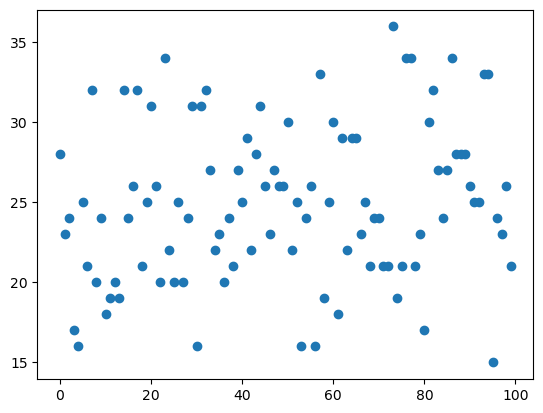

In [2]:
"""
Measuring the Mean, Part 1: Counts Versus Interval Number

The amount of jitter seems normal.
"""


T, N = 10, 100
counts = bin_events(events, T=T) # T is the bin time.
plt.scatter(arange(N), counts[:N])

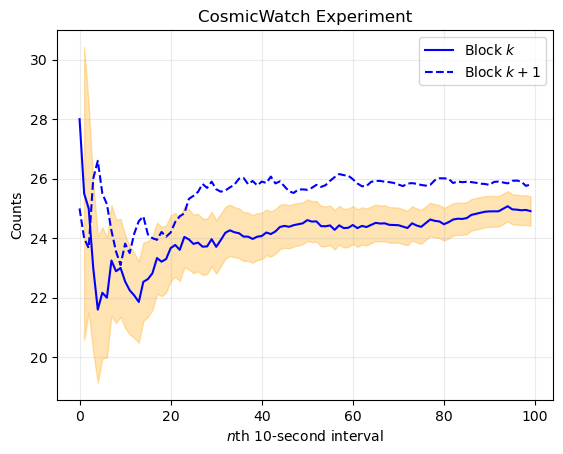

In [3]:
"""
Measuring the Mean, Part 2: Running Average.
Measuring the Mean, Part 3: Error Bars.

Yes, the running average does appear to converge to some value.
"""


# Extract 100 10-s bins and take statistics.
counts = bin_events(events, T=10) # T is the bin time.
N = 100 # Number of bins.
k = 0  # Which seris of N bins.
x, y_1 = arange(N), running_average(counts[k * N:(k + 1) * N])
x, y_2 = arange(N), running_average(counts[(k + 1) * N:(k + 2) * N])
sigma = std(counts[k * N:(k + 1) * N], ddof=1)

# Plot first 100, next 100, and error bar.
plt.plot(x, y_1,
         color='blue', label="Block $k$")
plt.plot(x, y_2,
         color='blue', linestyle="--", label="Block $k + 1$")
plt.fill_between(x[1:], y_1[1:] - sigma / sqrt(x[1:]), y_1[1:] + sigma / sqrt(x[1:]),
                 color='orange', alpha=0.3)
plt.grid(alpha=0.25)

# Cosmetics.
plt.title("CosmicWatch Experiment")
plt.xlabel('$n$th 10-second interval')
plt.ylabel('Counts')
plt.legend()
plt.show()

Average for first 100 10-s bins: 24.91.
Average for first 100 10-s bins: 25.81.
Error of first 100 10-s bins estimate: 0.4927955709495316.
Probability of a larger error 6.78%.


Text(0, 0.5, 'Number of Intervals')

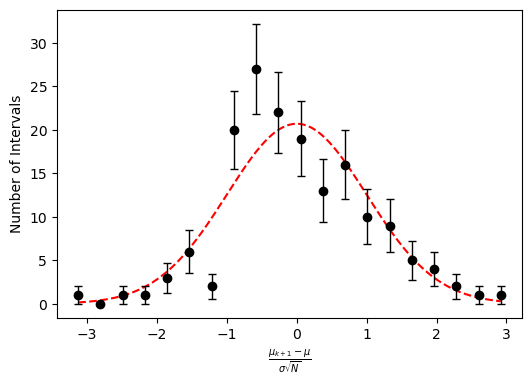

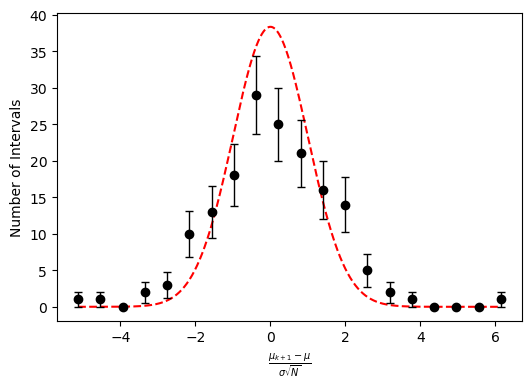

In [4]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Measuring the mean, part 4: reliability of estimated error bar.
"""


# Compare the first and second block of 100 intervals.
N = 100
avgs, stds = calc_block_stats(counts, N)
mu_0, mu_1 = avgs[0:2]
sigma_0 = stds[0] / sqrt(N)
p_larger = 200 * (1 - norm.cdf((mu_1 - mu_0) / sigma_0))
print(f"Average for first 100 10-s bins: {mu_0}.")
print(f"Average for first 100 10-s bins: {mu_1}.")
print(f"Error of first 100 10-s bins estimate: {sigma_0}.")
print(f"Probability of a larger error {p_larger:.2f}%.")

# Compare block average with average of ALL blocks.
errs = (avgs - average(avgs)) / std(avgs)
pops, edges = histogram(errs, bins=20)
centers = (edges[:-1] + edges[1:]) / 2
width = edges[1] - edges[0]
scaler = width * sum(pops)
fit_grid = linspace(min(centers), max(centers), 1000)

# Plot the above.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(centers, pops, yerr=sqrt(pops),
            fmt='o', c="k", capsize=3, elinewidth=1)
ax.plot(fit_grid, scaler * norm.pdf(fit_grid),
        zorder=-10, linestyle="--", color="r")
ax.set_xlabel(r"$\frac{\mu_{k+1} - \mu}{\sigma\sqrt{N}}$")
ax.set_ylabel("Number of Intervals")

# Compare (k+1)th average with (k)th average and error estimate.
errs = (avgs[1:] - avgs[:-1]) / (stds[:-1] / sqrt(N))
pops, edges = histogram(errs, bins=20)
centers = (edges[:-1] + edges[1:]) / 2
width = edges[1] - edges[0]
scaler = width * sum(pops)
fit_grid = linspace(min(centers), max(centers), 1000)

# Plot the above.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(centers, pops, yerr=sqrt(pops),
            fmt='o', c="k", capsize=3, elinewidth=1)
ax.plot(fit_grid, scaler * norm.pdf(fit_grid),
        zorder=-10, linestyle="--", color="r")
ax.set_xlabel(r"$\frac{\mu_{k+1} - \mu}{\sigma\sqrt{N}}$")
ax.set_ylabel("Number of Intervals")

10.223276855226503
0.9472212121509935
9.705834465745346
0.9410856642866173


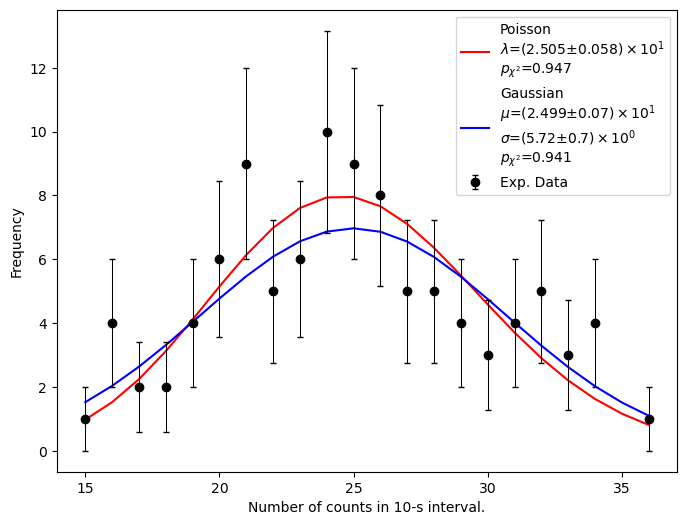

In [7]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Poisson versus Gaussian, part 1-3: Poisson fit for T=10.
"""


# Analysis parameters.
T = 10 # Interval time.
N = 100 # Number of intervals per block.
width = 1 # Histogram bin width.

# Histogram the number of muons per interval.
counts_anl = counts[k * N:(k + 1) * N]
counts = bin_events(events, T=T)
centers, freqs = integer_histogram(counts_anl, width=width)
centers, freqs = drop_zeros(centers, freqs)
scale = N * width
grid = arange(floor(centers)[0], ceil(centers)[-1] + 1)

# Fit Poisson distribution to experiment.
poiss_fit = lambda n, n_avg: scale * poisson.pmf(n, n_avg)
fit_result = fit_chi2(poiss_fit, [average(counts_anl)], centers, freqs, sqrt(freqs))
poiss_args, poiss_stds, poiss_chi2, poiss_p_chi2 = fit_result
poiss_rpt = format_sigfigs(poiss_args, poiss_stds)

# Fit Gaussian distribution to experiment.
norm_fit = lambda n, mu, sigma: scale * norm.pdf(n, mu, sigma)
fit_result = fit_chi2(norm_fit, [average(counts_anl), sqrt(average(counts_anl))],
                      centers, freqs, sqrt(freqs))
norm_args, norm_stds, norm_chi2, norm_p_chi2 = fit_result
norm_rpt = format_sigfigs(norm_args, norm_stds)

# Plot data with error bars and compare to fit.
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(centers, freqs, yerr=sqrt(freqs), label="Exp. Data",
            fmt='o', c="k", capsize=2, elinewidth=0.75, zorder=10)
ax.plot(grid, poiss_fit(grid, *poiss_args),
        c="r", label=f"Poisson\n$\\lambda$={poiss_rpt[0]}\n$p_{{\\chi^2}}$={poiss_p_chi2:.3f}")
ax.plot(grid, norm_fit(grid, *norm_args),
        c="b", label=f"Gaussian\n$\\mu$={norm_rpt[0]}\n$\\sigma$={norm_rpt[1]}\n$p_{{\\chi^2}}$={norm_p_chi2:.3f}")
ax.set_xlabel(f"Number of counts in {T}-s interval.")
ax.set_ylabel("Frequency")
ax.legend()

# Report.
print(poiss_chi2)
print(poiss_p_chi2)
print(norm_chi2)
print(norm_p_chi2)

35.87728050383983
0.9462956383466785
26.980395300950356
0.9968117464002837


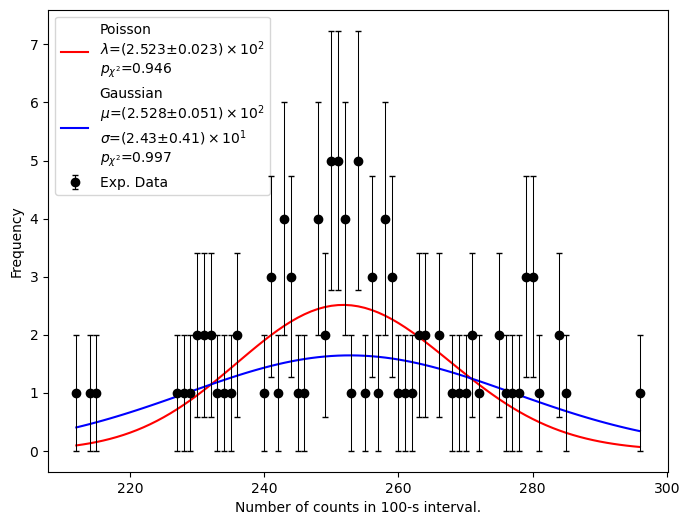

In [13]:
"""
XS1: In-Class Exercise X1.3 "Poisson statistics"

Poisson versus Gaussian, part 4: Poisson and Gaussian fit for T=10.
"""


# Analysis parameters.
T = 100 # Interval time.
N = 100 # Number of intervals per block.
width = 1 # Histogram bin width.

# Histogram the number of muons per interval.
counts = bin_events(events, T=T)
counts_anl = counts[k * N:(k + 1) * N]
counts = bin_events(events, T=T)
centers, freqs = integer_histogram(counts_anl, width=width)
centers, freqs = drop_zeros(centers, freqs)
scale = N * width
grid = arange(floor(centers)[0], ceil(centers)[-1] + 1)

# Fit Poisson distribution to experiment.
poiss_fit = lambda n, n_avg: scale * poisson.pmf(n, n_avg)
fit_result = fit_chi2(poiss_fit, [average(counts_anl)], centers, freqs, sqrt(freqs))
poiss_args, poiss_stds, poiss_chi2, poiss_p_chi2 = fit_result
poiss_rpt = format_sigfigs(poiss_args, poiss_stds)

# Fit Gaussian distribution to experiment.
norm_fit = lambda n, mu, sigma: scale * norm.pdf(n, mu, sigma)
fit_result = fit_chi2(norm_fit, [average(counts_anl), sqrt(average(counts_anl))],
                      centers, freqs, sqrt(freqs))
norm_args, norm_stds, norm_chi2, norm_p_chi2 = fit_result
norm_rpt = format_sigfigs(norm_args, norm_stds)

# Plot data with error bars and compare to fit.
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(centers, freqs, yerr=sqrt(freqs), label="Exp. Data",
            fmt='o', c="k", capsize=2, elinewidth=0.75, zorder=10)
ax.plot(grid, poiss_fit(grid, *poiss_args),
        c="r", label=f"Poisson\n$\\lambda$={poiss_rpt[0]}\n$p_{{\\chi^2}}$={poiss_p_chi2:.3f}")
ax.plot(grid, norm_fit(grid, *norm_args),
        c="b", label=f"Gaussian\n$\\mu$={norm_rpt[0]}\n$\\sigma$={norm_rpt[1]}\n$p_{{\\chi^2}}$={norm_p_chi2:.3f}")
ax.set_xlabel(f"Number of counts in {T}-s interval.")
ax.set_ylabel("Frequency")
ax.legend()

# Report.
print(poiss_chi2)
print(poiss_p_chi2)
print(norm_chi2)
print(norm_p_chi2)